# Calculating physical properties of galaxy halos

In this notebook, I will demonstrate the method used to calculate galaxy properties, such as stellar mass, half-mass radius, and velocity dispersion. These are the properties that we will use to compare with observational data. We will use several functions that were defined in the Halo Manipulation notebook, which we've copied to the `analysis` module in the repository

In [1]:
import matplotlib
matplotlib.use("TKAgg")
%matplotlib inline

import pynbody
import numpy as np
import seaborn as sns
from matplotlib import pyplot
from analysis import load_snapshot_and_halos
import analysis.conf as conf

pynbody.logger.setLevel(pynbody.logging.ERROR)

/Users/kevinyu/Dev/ubiquitous-meow/env/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
s, h = load_snapshot_and_halos(conf.SAMPLE)
halo = h[6]

/Users/kevinyu/Dev/ubiquitous-meow/env/lib/python2.7/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'omegaM0'=3.09e-01
  name, value), RuntimeWarning)
/Users/kevinyu/Dev/ubiquitous-meow/env/lib/python2.7/site-packages/pynbody/simdict.py:92: RuntimeWarning: Assuming default value for property 'omegaL0'=6.91e-01
  name, value), RuntimeWarning)


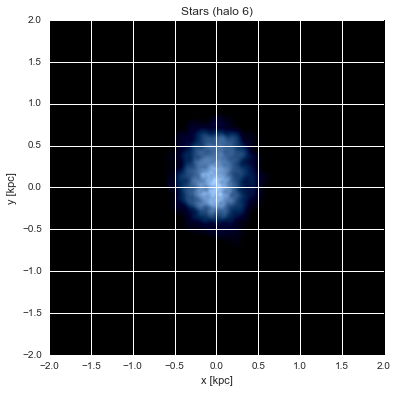

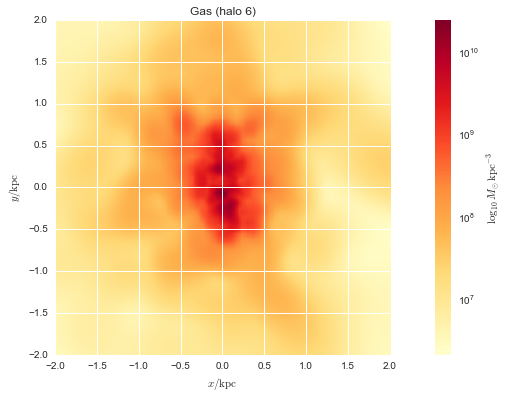

In [3]:
pyplot.rcParams['figure.figsize'] = 16, 6
with pynbody.analysis.halo.center(halo, mode="pot"), pynbody.analysis.angmom.faceon(halo):
    pynbody.plot.stars.render(halo, width="4 kpc")
    pyplot.title("Stars (halo 6)")
    pyplot.figure()
    pynbody.plot.image(halo.g, width="4 kpc", cmap="YlOrRd")
    pyplot.title("Gas (halo 6)")


In [4]:
results = {}

## $R_{halfmass}$

Calculate half-mass radius (radius enclosing half the total mass in a 2D profile face-on profile) by using the function we defined in the Halo Manipulation notebook, which generates a mass profile.

In [5]:
from analysis.transform import get_halfmass_radius

results["R_halfmass"] = get_halfmass_radius(halo)
results["R_halfmass"]

SimArray(0.5029921622017868, 'kpc')

## $M_{star}$

Calculate the stellar mass of the halo by summing up all the star particles.

In [6]:
results["M_star"] = pynbody.halo.SimArray(sum(halo.s["mass"]), units=halo.s["mass"].units)
results["M_star"]

SimArray(4441917408.154874, 'Msol')

## $v_{disp}$

Calculating the velocity dispersion is not as straightforward. The velocity dispersion we want is a statistical measurement of the variance of particle velocities along the line of sight. Observers can measure the line-of-sight velocity dispersion by analyzing the width of spectral features, for example.

We can rotate our halo to maximize the velocity dispersion by rotating it side-on relative to the angular momentum vector (our line of sight will be in the same plane as the rotational velocities of particles). Alternatively, we can rotate our halo so as to minimize our velocity dispersion, by going face-on along the angular momentum vector (rotational velcoity will always be perpendicular to our line of sight.

Because of that, we will choose some _typical_ velocity dispersion, and account for the uncertainty. Although we can determine the expected value of the line-of-sight velocity dispersion both analytically and through Monte-Carlo trials at random orientations, for the sake of time and simplicity we will just take a geometric average of the measurement parallel to the plane of the galaxy and the measurement perpendicular to the plane of the galaxy.

$v_{disp} = \sqrt{\sigma_{x}^2 + \sigma_{z}^2}$

In [7]:
def get_velocity_dispersion(halo):
    """Calculate velocity dispersion of halo

    Returns geometric mean of the std dev of velocity components perpendicular to ang mom vector
    """
    with pynbody.analysis.halo.center(halo, mode="pot"), pynbody.analysis.angmom.faceon(halo):
        x_velocities = halo.s["vel"][:, 0]
        z_velocities = halo.s["vel"][:, 2]
        return np.sqrt(pow(np.std(x_velocities), 2) + pow(np.std(z_velocities), 2))

results["v_disp"] = pynbody.halo.SimArray(get_velocity_dispersion(halo), units=halo.s["vel"].units)
results["v_disp"]

SimArray(106.19408352752046, 'km s**-1')

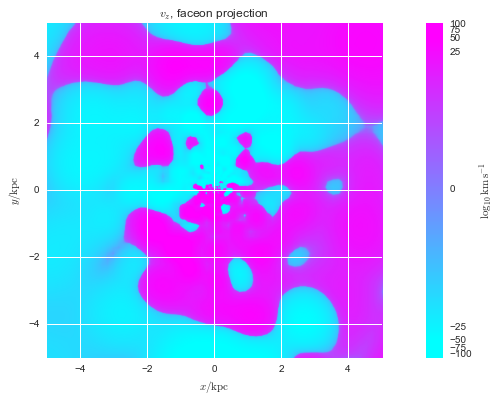

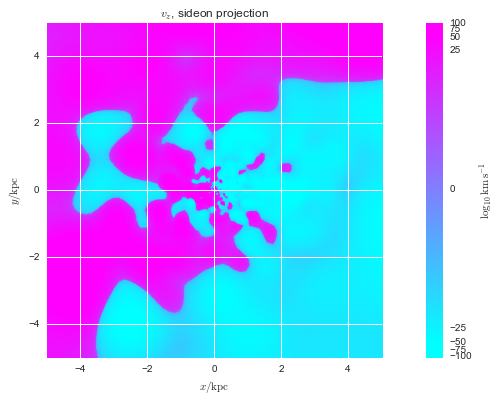

In [8]:
pyplot.figure()
with pynbody.analysis.halo.center(halo, mode="pot"), pynbody.analysis.angmom.faceon(halo):
    pynbody.plot.image(halo.s, qty="vz", cmap="cool")
    pyplot.gca().get_images()[0].set_clim([-50, 50])
    pyplot.title("$v_z$, faceon projection")
    
pyplot.figure()
with pynbody.analysis.halo.center(halo, mode="pot"), pynbody.analysis.angmom.sideon(halo):
    pynbody.plot.image(halo.s, qty="vz", cmap="cool")
    pyplot.gca().get_images()[0].set_clim([-50, 50])
    pyplot.title("$v_z$, sideon projection")